In [12]:
# data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 15

# machine learning models
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

# statistical test
from scipy.stats import ranksums


## Import Data

In [13]:
avi = pd.read_csv('SnowWeatherCleanROS.csv')
avi.head()

,Unnamed: 0,avi_danger,avg_wind,temp_max_swing,temp_max_swing_from_avg,year,month,day,temp_max,temp_min,...,prevailing_wind_E_2,prevailing_wind_N_2,prevailing_wind_NE_2,prevailing_wind_NW_2,prevailing_wind_S_2,prevailing_wind_SE_2,prevailing_wind_SW_2,prevailing_wind_W_2,three_day_snow_2,next_day_avi_danger
0,0,1.0,20.58,0.0,0.0,2010.0,12.0,20.0,15,5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.2,3.0
1,1,3.0,35.12,3.0,0.0,2010.0,12.0,21.0,18,10,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.3,2.0
2,2,2.0,33.78,-3.0,0.0,2010.0,12.0,22.0,15,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,3.0
3,3,3.0,31.32,0.0,0.0,2010.0,12.0,23.0,15,6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,2.0
4,4,2.0,32.44,2.0,1.4,2010.0,12.0,24.0,17,9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.3,2.0


In [14]:
avi = avi.drop(['Unnamed: 0'], axis=1)
x = avi.iloc[:, 0:avi.shape[1]-2]
y = avi.iloc[:, avi.shape[1]-1]
avi = avi[avi['avi_danger'].notnull()]
avi = avi[avi.avi_danger != 5]
avi = avi[avi.next_day_avi_danger != 5] 

print(x.shape)
print(y.shape)

(1892, 70)
(1892,)


In [17]:
# prepare models
models = []
models.append(('Logistic Reg', LogisticRegression(tol = 0.01, penalty = 'none', C = 100, max_iter = 100000)))
models.append(('Decision Tree', DecisionTreeClassifier(min_samples_split = 2, min_samples_leaf = 1, max_depth = 80)))
models.append(('Random Forest', RandomForestClassifier(n_estimators = 200, min_samples_split = 2, min_samples_leaf = 2, 
                                                       max_features = 'sqrt', max_depth = 60, bootstrap = True)))
models.append(('SVM', SVC(kernel = 'rbf', gamma = 0.1, C = 1000)))
models.append(('Gradient Boosting', GradientBoostingClassifier(n_estimators = 250, max_depth = 4, learning_rate = 0.15)))
models.append(('K Nearest Neighbors', KNeighborsClassifier(p = 2, n_neighbors = 1, leaf_size = 18)))
models.append(('Extra Trees', ExtraTreesClassifier(n_estimators = 1600, min_samples_split = 2, min_samples_leaf = 2,
                                                   max_features = 'sqrt', max_depth = 50, bootstrap = False)))


In [18]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    cv_results = model_selection.cross_val_score(model, x, y, cv=10, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/Users/lowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1320: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lowell/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logi

Logistic Reg: 0.597789 (0.023739)
Decision Tree: 0.699891 (0.087861)
Random Forest: 0.796578 (0.058101)
SVM: 0.727391 (0.146607)
Gradient Boosting: 0.749499 (0.061794)
K Nearest Neighbors: 0.646475 (0.105872)
Extra Trees: 0.805001 (0.054766)


Text(0, 0.5, 'Accuracy')

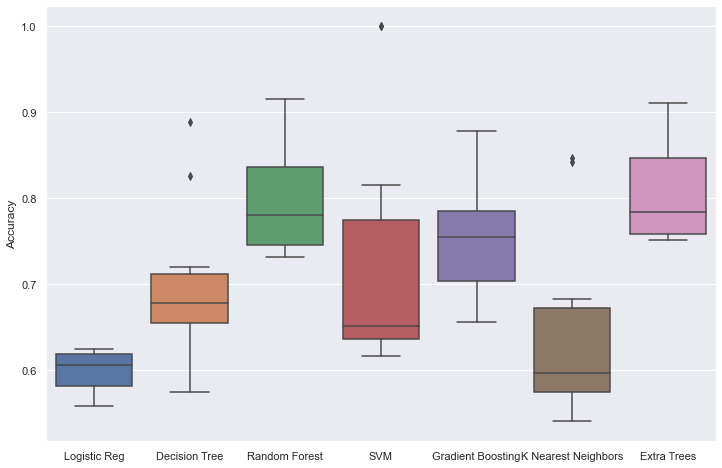

In [23]:
sns.set(font_scale=1)
boxplot = sns.boxplot(data=results)
boxplot.set_xticklabels(names)
plt.ylabel("Accuracy")

In [24]:
uncorrected_pvals = []
comparison_names = []
for i in range(len(results)):
    for j in range(i+1,len(results)):
        print("%20s: %f, %20s: %f, \tp = %f" % (names[i], np.mean(results[i]), 
                                          names[j], np.mean(results[j]),
                                          ranksums(results[i],results[j])[1]))
        uncorrected_pvals.append(ranksums(results[i],results[j])[1])
        comparison_names.append((names[i],names[j]))

        Logistic Reg: 0.597789,        Decision Tree: 0.699891, 	p = 0.001499
        Logistic Reg: 0.597789,        Random Forest: 0.796578, 	p = 0.000157
        Logistic Reg: 0.597789,                  SVM: 0.727391, 	p = 0.000881
        Logistic Reg: 0.597789,    Gradient Boosting: 0.749499, 	p = 0.000157
        Logistic Reg: 0.597789,  K Nearest Neighbors: 0.646475, 	p = 0.677585
        Logistic Reg: 0.597789,          Extra Trees: 0.805001, 	p = 0.000157
       Decision Tree: 0.699891,        Random Forest: 0.796578, 	p = 0.010165
       Decision Tree: 0.699891,                  SVM: 0.727391, 	p = 0.520523
       Decision Tree: 0.699891,    Gradient Boosting: 0.749499, 	p = 0.082099
       Decision Tree: 0.699891,  K Nearest Neighbors: 0.646475, 	p = 0.104110
       Decision Tree: 0.699891,          Extra Trees: 0.805001, 	p = 0.010165
       Random Forest: 0.796578,                  SVM: 0.727391, 	p = 0.082099
       Random Forest: 0.796578,    Gradient Boosting: 0.749499, 

In [25]:
from statsmodels.stats.multitest import multipletests

(significant, corected_pval, _, _) = multipletests(uncorrected_pvals, method='fdr_bh')

for i in range(len(comparison_names)):
    print("%40s: %f \t%s" % (comparison_names[i],corected_pval[i],significant[i]))

       ('Logistic Reg', 'Decision Tree'): 0.006295 	True
       ('Logistic Reg', 'Random Forest'): 0.001099 	True
                 ('Logistic Reg', 'SVM'): 0.004624 	True
   ('Logistic Reg', 'Gradient Boosting'): 0.001099 	True
 ('Logistic Reg', 'K Nearest Neighbors'): 0.705457 	False
         ('Logistic Reg', 'Extra Trees'): 0.001099 	True
      ('Decision Tree', 'Random Forest'): 0.023719 	True
                ('Decision Tree', 'SVM'): 0.575315 	False
  ('Decision Tree', 'Gradient Boosting'): 0.114938 	False
('Decision Tree', 'K Nearest Neighbors'): 0.136644 	False
        ('Decision Tree', 'Extra Trees'): 0.023719 	True
                ('Random Forest', 'SVM'): 0.114938 	False
  ('Random Forest', 'Gradient Boosting'): 0.163876 	False
('Random Forest', 'K Nearest Neighbors'): 0.021854 	True
        ('Random Forest', 'Extra Trees'): 0.705457 	False
            ('SVM', 'Gradient Boosting'): 0.138860 	False
          ('SVM', 'K Nearest Neighbors'): 0.114938 	False
                  ('SV